# Validate raw PSD

author: steeve.laquitaine@sorbonne-university.fr  
date: 11.06.2025  
purpose: validate raw psd



Reviewer 2.4: in depth analysis of PSD of raw trace

Reviewer 3.12: power law fit in spiking band




## Setup

1. run pipelines from src.pipes.validation.psd to compute psds.

2. activate spikebias and run notebook



In [43]:
%%time

# import libs
%load_ext autoreload
%autoreload 2


# import packages
import os
import numpy as np
import spikeinterface as si
import copy 
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd

# setup project path
proj_path = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(proj_path)

from src.nodes.validation import power

# setup paths
RAW_PATH_nv = os.path.join(proj_path, "dataset/00_raw/recording_marques_smith/")
RAW_PATH_ns = os.path.join(proj_path, "dataset/00_raw/recording_npx_spont/")
RAW_PATH_ne = os.path.join(proj_path, "dataset/00_raw/recording_npx_evoked/")
RAW_PATH_hv1 = os.path.join(proj_path, "dataset/00_raw/recording_horvath_probe1/")
RAW_PATH_hv2 = os.path.join(proj_path, "dataset/00_raw/recording_horvath_probe2/")
RAW_PATH_hv3 = os.path.join(proj_path, "dataset/00_raw/recording_horvath_probe3/")
RAW_PATH_hs1 = os.path.join(proj_path, "dataset/00_raw/recording_dense_probe1/")
RAW_PATH_hs2 = os.path.join(proj_path, "dataset/00_raw/recording_dense_probe2/")
RAW_PATH_hs3 = os.path.join(proj_path, "dataset/00_raw/recording_dense_probe3/")

# setup raw psd paths
# neuropixels
RAW_PSD_PATH_NS = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_npx_spont.npy")
RAW_PSD_PATH_NE = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_npx_evoked.npy")
RAW_PSD_PATH_NB = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_npx_buccino.npy")
RAW_PSD_PATH_NV = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_marques_smith.npy")

# horvath
RAW_PSD_PATH_HV1 = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_horvath_probe1.npy")
RAW_PSD_PATH_HV2 = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_horvath_probe2.npy")
RAW_PSD_PATH_HV3 = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_horvath_probe3.npy")

# dense
RAW_PSD_PATH_HS1 = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_dense_probe1.npy")
RAW_PSD_PATH_HS2 = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_dense_probe2.npy")
RAW_PSD_PATH_HS3 = os.path.join(proj_path, "dataset/01_intermediate/psd_raw_dense_probe3.npy")

# setup plot parameters
matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000          # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency
prm["SFREQ_NV"] = 30000          # sampling frequency
prm["SFREQ_NS"] = 40000        # sampling frequency
prm["SFREQ_NB"] = 32000
prm["SFREQ_NE"] = 20000

# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green


# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

# parameterize
FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

SAVE_FIG = True
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 455 µs, sys: 0 ns, total: 455 µs
Wall time: 486 µs


## Custom functions

In [26]:
def print_slope(alpha):
    print(f"\u03B1={np.round(np.mean(alpha),1)}\u00B1{np.round(np.std(alpha),1)}")


def get_slope_df(data: list, exp, layer):
    df = pd.DataFrame()
    df["Alpha"] = np.negative(data)
    df["Experiment"] = exp
    df["Layer"] = layer
    return df

## Load datasets

In [ ]:
%%time

# load neuropixels traces
RawNV = si.load_extractor(RAW_PATH_nv)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)

# Load dense probe traces (depth 1,2,3)
# horvath data
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHV3 = si.load_extractor(RAW_PATH_hv3)

# biophysical simulation
RawHS1 = si.load_extractor(RAW_PATH_hs1)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
RawHS3 = si.load_extractor(RAW_PATH_hs3)

# 4 - get good sites (in cortex) **********************

# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]

# silico
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]

# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]

# vivo
site_ly_nv = RawNV.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]

# probe 2 (select L4 and L5)
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]

# probe 3 (select L6)
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]

# probe 2
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]

# probe 3
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# 5 - load PSDs ****************************************

# neuropixels
psd_raw_nv = np.load(RAW_PSD_PATH_NV, allow_pickle=True).item()
psd_raw_ne = np.load(RAW_PSD_PATH_NE, allow_pickle=True).item()
psd_raw_ns = np.load(RAW_PSD_PATH_NS, allow_pickle=True).item()
psd_raw_nb = np.load(RAW_PSD_PATH_NB, allow_pickle=True).item()

# horvath
psd_raw_hv1 = np.load(RAW_PSD_PATH_HV1, allow_pickle=True).item()
psd_raw_hv2 = np.load(RAW_PSD_PATH_HV2, allow_pickle=True).item()
psd_raw_hv3 = np.load(RAW_PSD_PATH_HV3, allow_pickle=True).item()

# dense probe
psd_raw_hs1 = np.load(RAW_PSD_PATH_HS1, allow_pickle=True).item()
psd_raw_hs2 = np.load(RAW_PSD_PATH_HS2, allow_pickle=True).item()
psd_raw_hs3 = np.load(RAW_PSD_PATH_HS3, allow_pickle=True).item()

## Plot

/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:842: RuntimeWarning: divide by zero encountered in log10
  log_freq = np.array([np.log10(out_raw_vivo["freq"])]).T
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:843: RuntimeWarning: divide by zero encountered in log10
  good_ix = np.where(np.log10(out_raw_vivo["freq"]) != -np.inf)[0]
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:800: RuntimeWarning: divide by zero encountered in log10
  log_freq = np.array([np.log10(powers["freq"])]).T
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:802: RuntimeWarning: divide by zero encountered in log10
  (np.log10(powers["freq"]) != -np.inf)
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:800: RuntimeWarning: divide by zero encountered in log10
  log_freq = np.array([np.log10(powers["freq"])]).T
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:802: RuntimeWarning: divid


LFP band
α=-2.3±0.2
α=-0.6±0.1
α=-0.3±0.0
α=-0.5±0.2
α=-0.3±0.0

Spiking band
α=-1.6±0.3
α=-0.9±0.3
α=-0.5±0.4
α=-0.6±0.4
α=-0.3±0.2


n=272 sites
n=226 sites
n=202 sites
n=202 sites
n=297 sites

Power SNR
SNR: 3.4282140041913167e-05
SNR: 0.25840365458981124
SNR: 0.03106586872815669
SNR: 0.003623314692136443
SNR: 0.052489526110957974
SNR: 0.37626884325019844


/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:800: RuntimeWarning: divide by zero encountered in log10
  log_freq = np.array([np.log10(powers["freq"])]).T
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:802: RuntimeWarning: divide by zero encountered in log10
  (np.log10(powers["freq"]) != -np.inf)
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:800: RuntimeWarning: divide by zero encountered in log10
  log_freq = np.array([np.log10(powers["freq"])]).T
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:802: RuntimeWarning: divide by zero encountered in log10
  (np.log10(powers["freq"]) != -np.inf)
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:800: RuntimeWarning: divide by zero encountered in log10
  log_freq = np.array([np.log10(powers["freq"])]).T
/home/steeve/steeve/epfl/code/spikebias/src/nodes/validation/power.py:802: RuntimeWarning: divide by zero encountered in log10
  

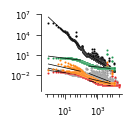

In [ ]:
%%time

# horvath vivo (all layers)
# L1 (probe 1)
psd_raw_hv1_L1 = copy.copy(psd_raw_hv1)
psd_raw_hv1_L1["power"] = psd_raw_hv1["power"][site_ly_hv1[sites_hv1] == "L1", :]

# L23 (probe 1)
psd_raw_hv1_L23 = copy.copy(psd_raw_hv1)
psd_raw_hv1_L23["power"] = psd_raw_hv1["power"][site_ly_hv1[sites_hv1] == "L2_3", :]

# L4 (probe 2)
psd_raw_hv2_L4 = copy.copy(psd_raw_hv2)
psd_raw_hv2_L4["power"] = psd_raw_hv2["power"][site_ly_hv2[sites_hv2] == "L4", :]

# L5 (probe 2)
psd_raw_hv2_L5 = copy.copy(psd_raw_hv2)
psd_raw_hv2_L5["power"] = psd_raw_hv2["power"][site_ly_hv2[sites_hv2] == "L5", :]
# L6 (probe 3)
psd_raw_hv3_L6 = copy.copy(psd_raw_hv3)
psd_raw_hv3_L6["power"] = psd_raw_hv3["power"][site_ly_hv3[sites_hv3] == "L6", :]

# sites in target layers in each probe
psd_all_hv = dict()
psd_all_hv["power"] = np.vstack(
    [
        psd_raw_hv1_L1["power"],
        psd_raw_hv1_L23["power"],
        psd_raw_hv2_L4["power"],
        psd_raw_hv2_L5["power"],
        psd_raw_hv3_L6["power"],
    ]
)
psd_all_hv["freq"] = psd_raw_hv1["freq"]


# horvath biophy. spont. (all layers) **************************
# L1 (probe 1)
psd_raw_hs1_L1 = copy.copy(psd_raw_hs1)
psd_raw_hs1_L1["power"] = psd_raw_hs1["power"][site_ly_hs1[sites_hs1] == "L1", :]
# L23 (probe 1)
psd_raw_hs1_L23 = copy.copy(psd_raw_hs1)
psd_raw_hs1_L23["power"] = psd_raw_hs1["power"][site_ly_hs1[sites_hs1] == "L2_3", :]
# L4 (probe 2)
psd_raw_hs2_L4 = copy.copy(psd_raw_hs2)
psd_raw_hs2_L4["power"] = psd_raw_hs2["power"][site_ly_hs2[sites_hs2] == "L4", :]
# L5 (probe 2)
psd_raw_hs2_L5 = copy.copy(psd_raw_hs2)
psd_raw_hs2_L5["power"] = psd_raw_hs2["power"][site_ly_hs2[sites_hs2] == "L5", :]
# L6 (probe 3)
psd_raw_hs3_L6 = copy.copy(psd_raw_hs3)
psd_raw_hs3_L6["power"] = psd_raw_hs3["power"][site_ly_hs3[sites_hs3] == "L6", :]

# sites in target layers in each probe
psd_all_hs = dict()
psd_all_hs["power"] = np.vstack(
    [
        psd_raw_hs1_L1["power"],
        psd_raw_hs1_L23["power"],
        psd_raw_hs2_L4["power"],
        psd_raw_hs2_L5["power"],
        psd_raw_hs3_L6["power"],
    ]
)
psd_all_hs["freq"] = psd_raw_hs1["freq"]


FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# Fit panel ************************************************************

ax1, alphas_lfp_hv, alphas_spiking_hv = power.plot_fits_all(
    ax1, psd_all_hv, prm["SFREQ_HV"], cl["COLOR_HV"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_nv, alphas_spiking_nv = power.plot_fits_all(
    ax1, psd_raw_nv, prm["SFREQ_NV"], cl["COLOR_NV"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ns, alphas_spiking_ns = power.plot_fits_all(
    ax1, psd_raw_ns, prm["SFREQ_NS"], cl["COLOR_NS"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ne, alphas_spiking_ne = power.plot_fits_all(
    ax1, psd_raw_ne, prm["SFREQ_NE"], cl["COLOR_NE"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_hs, alphas_spiking_hs = power.plot_fits_all(
    ax1, psd_all_hs, prm["SFREQ_HS"], cl["COLOR_HS"], pm, pm_fit1, pm_fit2
)

# axes legend
# esthetics
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.spines[["top", "right"]].set_visible(False)
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax1.spines["left"].set_position(("axes", -0.05))

# report slopes
# lfp band
print("\nLFP band")
print_slope(alphas_lfp_hv)
print_slope(alphas_lfp_nv)
print_slope(alphas_lfp_ns)
print_slope(alphas_lfp_ne)
print_slope(alphas_lfp_hs)

# spiking band
print("\nSpiking band")
print_slope(alphas_spiking_hv)
print_slope(alphas_spiking_nv)
print_slope(alphas_spiking_ns)
print_slope(alphas_spiking_ne)
print_slope(alphas_spiking_hs)

# print sites
print("\n")
print(f"""n={psd_all_hv["power"].shape[0]} sites""")
print(f"""n={psd_raw_nv["power"].shape[0]} sites""")
print(f"""n={psd_raw_ns["power"].shape[0]} sites""")
print(f"""n={psd_raw_ne["power"].shape[0]} sites""")
print(f"""n={psd_all_hs["power"].shape[0]} sites""")


# SNR **************************
print("\nPower SNR")

out_hv = power.get_power_snr(psd_all_hv["power"], psd_all_hv["freq"], 300, 6000, 90)
out_nv = power.get_power_snr(psd_raw_nv["power"], psd_raw_nv["freq"], 300, 6000, 90)
out_ns = power.get_power_snr(psd_raw_ns["power"], psd_raw_ns["freq"], 300, 6000, 90)
out_ne = power.get_power_snr(psd_raw_ne["power"], psd_raw_ne["freq"], 300, 6000, 90)
out_hs = power.get_power_snr(psd_all_hs["power"], psd_all_hs["freq"], 300, 6000, 90)
out_nb = power.get_power_snr(psd_raw_nb["power"], psd_raw_nb["freq"], 300, 6000, 90)

# save
if SAVE_FIG:
    plt.savefig("figures/7_reviews/fig1_raw_psd_all_circuit.svg",**savefig_cfg)